In [13]:
from google.colab import drive
drive.mount("/content/drive")

import pathlib, sys, random, numpy as np, torch, matplotlib as mpl, matplotlib.pyplot as plt

BASE = pathlib.Path("/content/drive/MyDrive/ctrl_style")
sys.path.append(str(BASE))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

mpl.rcParams.update({
    "figure.dpi": 140,
    "figure.figsize": (8, 4.5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 11,
})

print("BASE:", BASE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE: /content/drive/MyDrive/ctrl_style


In [14]:
!pip -q install sentence-transformers umap-learn scikit-learn spacy textstat tqdm
!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
from src.config import RepoPaths, CorpusConfig
from src.data import CorpusDataset
from src.embeddings import EmbeddingModel, EmbeddingModelConfig
from src.visualization import StyleEmbeddingVisualizer, UmapConfig
from src.evaluation import StyleTransferEvaluator  # если есть, можно не использовать

import pandas as pd
import textstat
from sklearn.decomposition import PCA


In [16]:
paths = RepoPaths(base=BASE)
corp_cfg = CorpusConfig(
    passages_csv=paths.data_processed / "passages.csv",
    text_col="text",
    author_col="author",
)

dataset = CorpusDataset(corp_cfg)
df_all = dataset.load_all()

print("Corpus preview:")
display(df_all.head())

print("\nPassages per author:")
display(df_all["author"].value_counts())


Corpus preview:


,text,author
0,[Illustration:\n\n GEORGE ALLEN\n PUBLISHER\n\...,Jane Austen
1,"Northanger\nAbbey, _its completeness, finish, ...",Jane Austen
2,"It is the larger, the more varied, the\nmore p...",Jane Austen
3,"The elopement of Lydia\nand Wickham is not, li...",Jane Austen
4,"But if the attempt were made, it would\ncertai...",Jane Austen



Passages per author:


,count
author,
Jane Austen,1732
Mark Twain,1317


Stylometric summary (length & FK grade):


len_words                       fk_grade                      \
                   mean        std  min  max      mean       std       min   
author                                                                       
Jane Austen  232.407621  18.908277  147  289  9.785989  3.906685  2.883083   
Mark Twain   226.066819  22.299531  146  293  8.401825  5.064007  0.239668   

                        
                   max  
author                  
Jane Austen  33.317593  
Mark Twain   53.136547

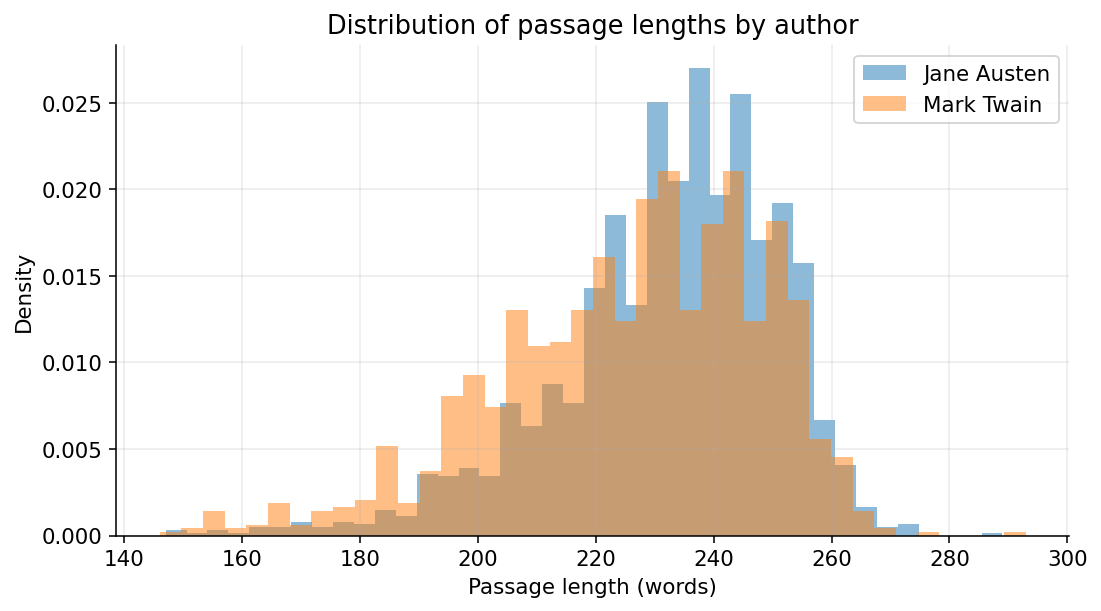

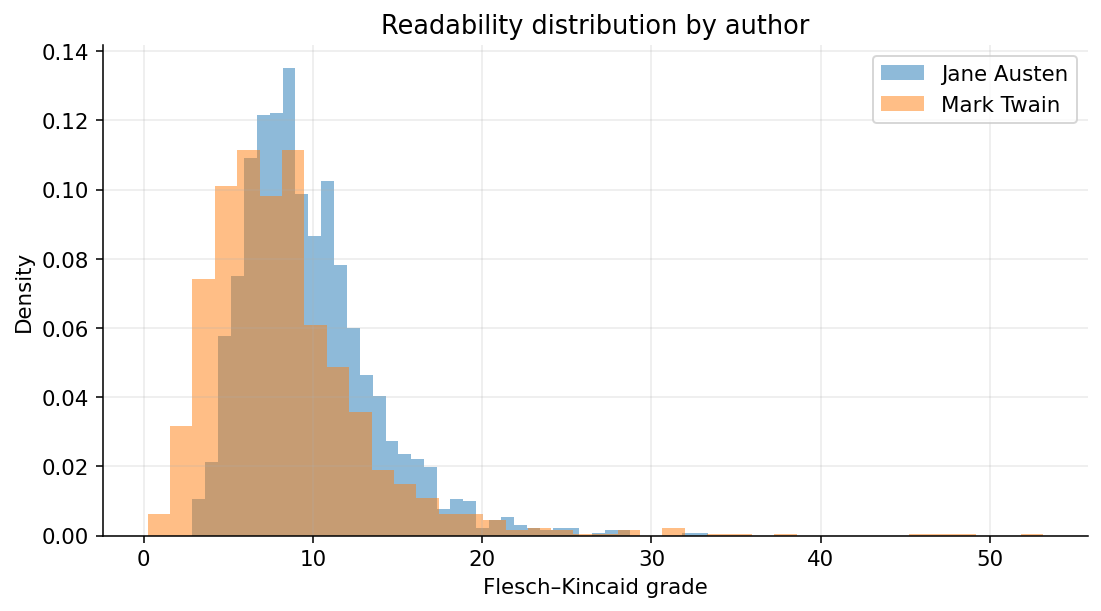

In [17]:
df_stats = df_all.copy()
df_stats["len_words"] = df_stats["text"].str.split().str.len()
df_stats["fk_grade"] = df_stats["text"].apply(textstat.flesch_kincaid_grade)

print("Stylometric summary (length & FK grade):")
display(
    df_stats.groupby("author")[["len_words", "fk_grade"]].agg(
        ["mean", "std", "min", "max"]
    )
)

plt.figure()
for author in df_stats["author"].unique():
    sub = df_stats[df_stats["author"] == author]
    plt.hist(
        sub["len_words"],
        bins=40,
        alpha=0.5,
        label=author,
        density=True,
    )
plt.xlabel("Passage length (words)")
plt.ylabel("Density")
plt.title("Distribution of passage lengths by author")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for author in df_stats["author"].unique():
    sub = df_stats[df_stats["author"] == author]
    plt.hist(
        sub["fk_grade"],
        bins=40,
        alpha=0.5,
        label=author,
        density=True,
    )
plt.xlabel("Flesch–Kincaid grade")
plt.ylabel("Density")
plt.title("Readability distribution by author")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
N_EXAMPLES = 2

for author in df_all["author"].unique():
    print("=" * 80)
    print(f"Author: {author}")
    print("-" * 80)
    samples = df_all[df_all["author"] == author].sample(N_EXAMPLES, random_state=SEED)
    for i, row in samples.reset_index(drop=True).iterrows():
        print(f"[Example {i+1}]")
        print(row["text"][:450].replace("\n", " "))
        print()


Author: Jane Austen
--------------------------------------------------------------------------------
[Example 1]
“I remember last Christmas at a little hop at the park, he danced from eight o’clock till four, without once sitting down.”   “Did he indeed?” cried Marianne with sparkling eyes, “and with elegance, with spirit?”  “Yes; and he was up again at eight to ride to covert.”  “That is what I like; that is what a young man ought to be. Whatever be his pursuits, his eagerness in them should know no moderation, and leave him no sense of fatigue.”  “Aye, ay

[Example 2]
“It is not that such a circumstance would now make me unhappy, but I cannot believe it. It seems an impossibility!—You cannot mean to say, that Harriet Smith has accepted Robert Martin. You cannot mean that he has even proposed to her again—yet. You only mean, that he intends it.”   “I mean that he has done it,” answered Mr. Knightley, with smiling but determined decision, “and been accepted.”   “Good God!” she cried.—“

In [19]:
target_authors = list(df_all["author"].unique())

df_subset = dataset.filter_authors(df_all, target_authors)
df_balanced = dataset.sample_per_author(df_subset, n_per_author=200, random_state=SEED)

print("Balanced subset sizes:")
display(df_balanced["author"].value_counts())


Balanced subset sizes:


,count
author,
Jane Austen,200
Mark Twain,200


In [20]:
emb_cfg = EmbeddingModelConfig(
    model_name="all-MiniLM-L6-v2",
    batch_size=32,
)
encoder = EmbeddingModel(emb_cfg)

df_emb = encoder.encode_dataframe(df_balanced, text_col="text", emb_col="emb")
X = np.stack(df_emb["emb"].values)
print("Embeddings shape:", X.shape)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Embeddings shape: (400, 384)


In [21]:
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)

viz = StyleEmbeddingVisualizer(
    UmapConfig(
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=SEED,
    )
)
X_umap = viz.project_umap(X)

df_emb = df_emb.copy()
df_emb["pca_x"], df_emb["pca_y"] = X_pca[:, 0], X_pca[:, 1]
df_emb["umap_x"], df_emb["umap_y"] = X_umap[:, 0], X_umap[:, 1]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


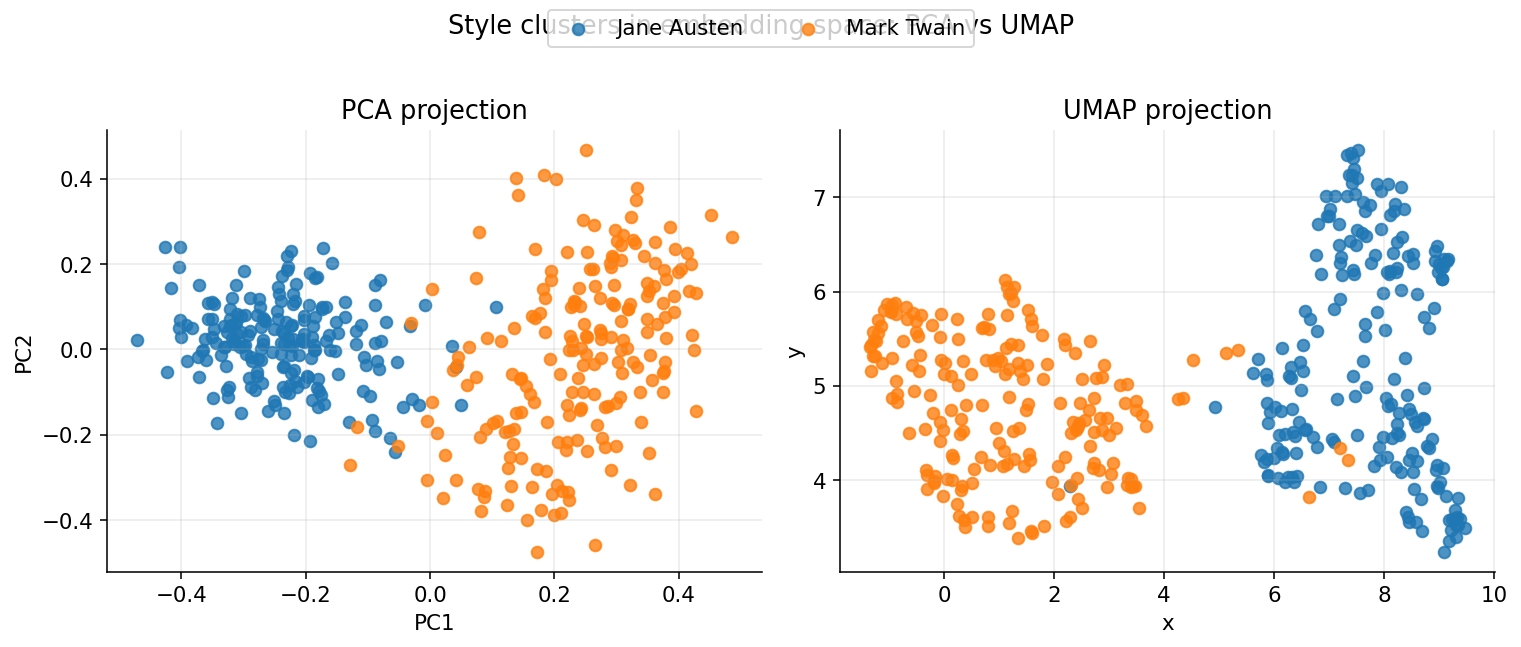

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

authors = df_emb["author"].unique()

for author in authors:
    sub = df_emb[df_emb["author"] == author]
    axes[0].scatter(sub["pca_x"], sub["pca_y"], alpha=0.8, label=author)
axes[0].set_title("PCA projection")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

for author in authors:
    sub = df_emb[df_emb["author"] == author]
    axes[1].scatter(sub["umap_x"], sub["umap_y"], alpha=0.8, label=author)
axes[1].set_title("UMAP projection")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(authors))

plt.suptitle("Style clusters in embedding space: PCA vs UMAP", y=1.02)
plt.tight_layout()
plt.show()


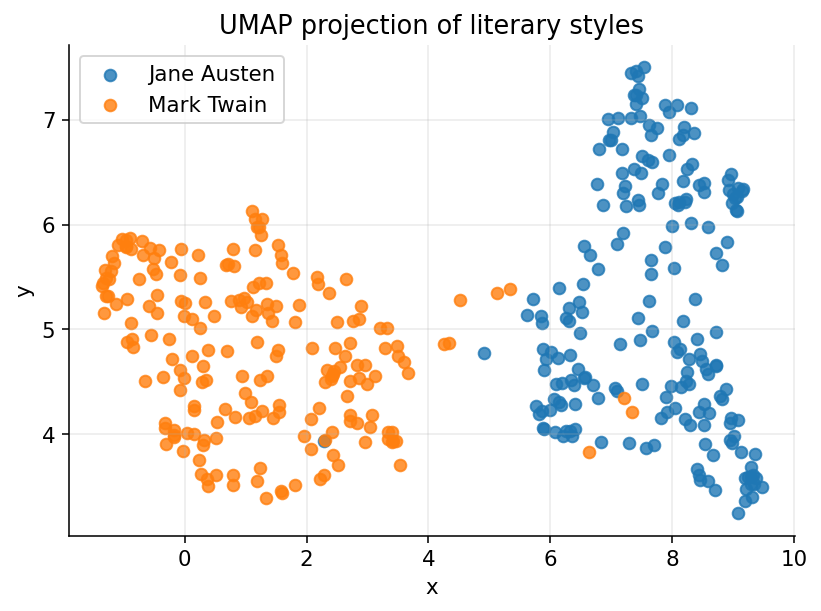

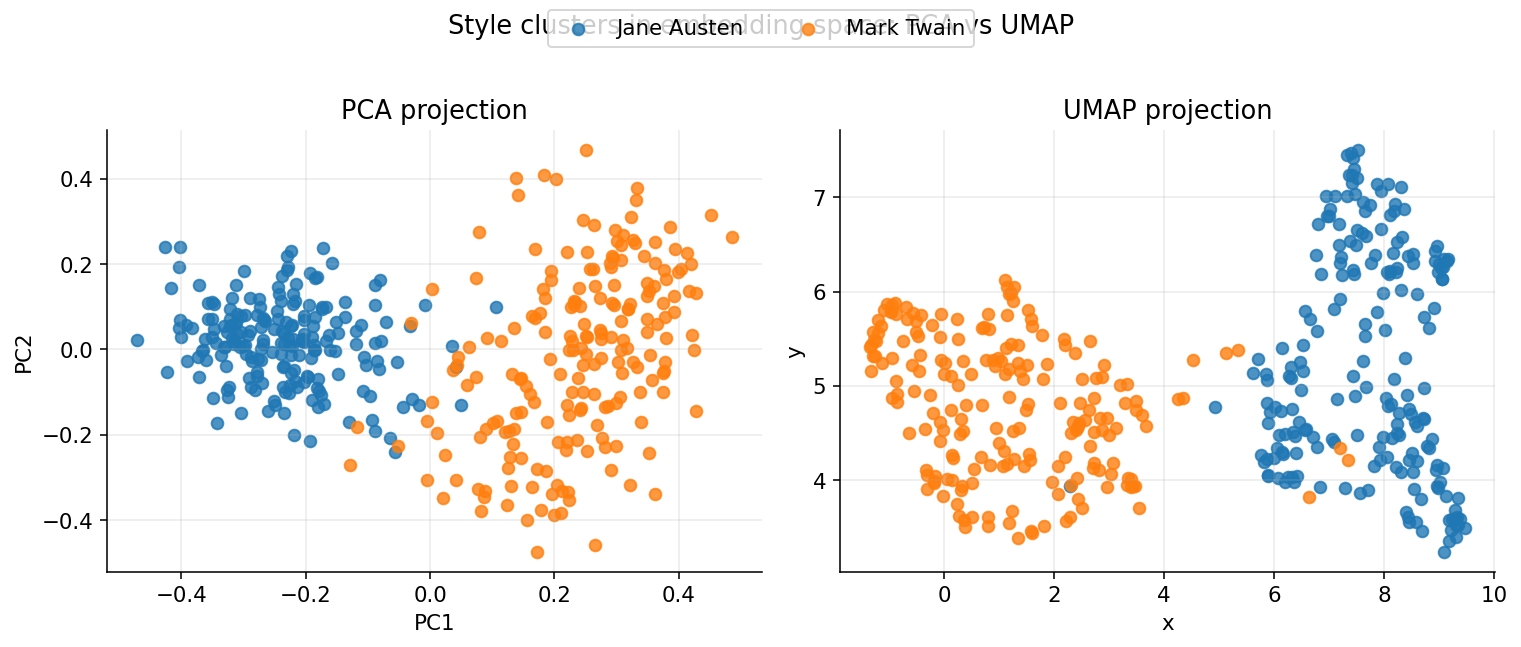

Saved figures:
 - /content/drive/MyDrive/ctrl_style/results/figures/umap_styles.png
 - /content/drive/MyDrive/ctrl_style/results/figures/pca_vs_umap_styles.png


In [24]:
paths.figures.mkdir(parents=True, exist_ok=True)

# UMAP
plt.figure(figsize=(6, 4.5))
for author in df_emb["author"].unique():
    sub = df_emb[df_emb["author"] == author]
    plt.scatter(sub["umap_x"], sub["umap_y"], alpha=0.8, label=author)
plt.xlabel("x")
plt.ylabel("y")
plt.title("UMAP projection of literary styles")
plt.legend()
plt.tight_layout()
umap_path = paths.figures / "umap_styles.png"
plt.savefig(umap_path, bbox_inches="tight")
plt.show()

# PCA vs UMAP
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
authors = df_emb["author"].unique()

for author in authors:
    sub = df_emb[df_emb["author"] == author]
    axes[0].scatter(sub["pca_x"], sub["pca_y"], alpha=0.8, label=author)
axes[0].set_title("PCA projection")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

for author in authors:
    sub = df_emb[df_emb["author"] == author]
    axes[1].scatter(sub["umap_x"], sub["umap_y"], alpha=0.8, label=author)
axes[1].set_title("UMAP projection")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(authors))

plt.suptitle("Style clusters in embedding space: PCA vs UMAP", y=1.02)
plt.tight_layout()
combo_path = paths.figures / "pca_vs_umap_styles.png"
plt.savefig(combo_path, bbox_inches="tight")
plt.show()

print("Saved figures:")
print(" -", umap_path)
print(" -", combo_path)
